In [1]:
import numpy as np
import cv2
import random
import math
import matplotlib.pyplot as plt

def flow_to_hsv(dx, dy, clip_magnitude=2.0):
    """
    Convert flow (dy, dx) to an HSV image for visualization.
    - Hue = flow direction
    - Saturation = 1
    - Value = scaled flow magnitude
    
    clip_magnitude: max magnitude to clip for normalization
    """
    # flow angle: range [-pi, pi]
    angle = np.arctan2(dy, dx)  # shape (H,W)
    # flow magnitude
    mag = np.sqrt(dy**2 + dx**2)
    
    # Normalize angle to [0..1] for Hue
    # angle in [-pi, pi], shift by +pi => [0, 2pi], then / (2*pi)
    angle_normalized = (angle + math.pi) / (2*math.pi)
    angle_normalized = np.clip(angle_normalized, 0, 1)
    
    # Clip magnitude for display & normalize to [0..1]
    mag_clipped = np.clip(mag, 0, clip_magnitude)
    mag_normalized = mag_clipped / clip_magnitude
    
    # HSV: 
    #   H = angle_normalized, S=1, V=mag_normalized
    # Then convert HSV -> RGB
    hsv = np.zeros((dy.shape[0], dy.shape[1], 3), dtype=np.float32)
    hsv[..., 0] = angle_normalized     # Hue
    hsv[..., 1] = 1.0                  # Saturation
    hsv[..., 2] = mag_normalized       # Value
    
    # Convert HSV to RGB for display
    hsv_8u = (hsv * 255).astype(np.uint8)
    rgb_8u = cv2.cvtColor(hsv_8u, cv2.COLOR_HSV2RGB)
    return rgb_8u


anns.shape: (540, 2, 512, 512)
imgs.shape: (540, 512, 512)
flows_all.shape: (540, 3, 512, 512)
Random index chosen: 350


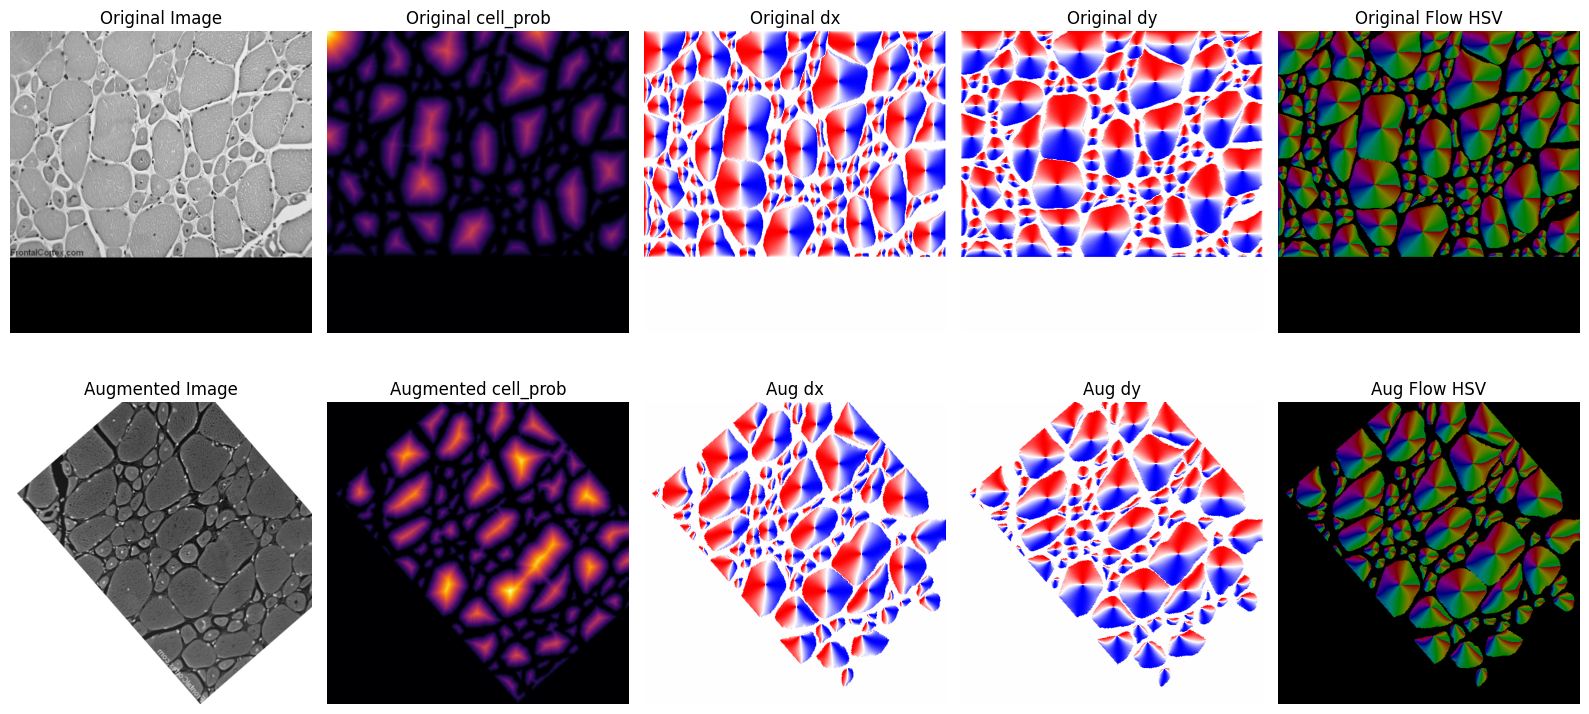

In [2]:
from SAMDataset import SAMDataset 

# Path to your labeled mask array and flows
Cellpose_path = '/Users/saahilsanganeriya/Documents/Saahil/PBL/SAMCellv2.0/dataset_processing/CellPose-train/'
anns_file = Cellpose_path + 'anns.npy'  # or wherever your .npy is
imgs_file = Cellpose_path + 'imgs.npy'
flows_file = Cellpose_path + 'flows.npy'  # Path to the precomputed flows.npy

# Load the arrays
anns = np.load(anns_file)
print("anns.shape:", anns.shape)

imgs = np.load(imgs_file)
print("imgs.shape:", imgs.shape)

flows = np.load(flows_file)
print("flows_all.shape:", flows.shape)  # Expected shape: (N, 3, H, W)

processor = None         # if you don't need a real SamProcessor

# We'll pass dummy weight_path=None
dataset = SAMDataset(imgs_file, flows_file, anns_file, processor, weight_path=None, crop_size=256)

# dataset.imgs => shape (N, H, W) or (N, H, W, 3)
# dataset.flows => shape (N, 3, H, W)

N = len(dataset.imgs)
idx = random.randint(0, N - 1)
print(f"Random index chosen: {idx}")

# ----------------------------------------------------------------------
# 2) Grab an image + flow from the dataset
#    We'll do it manually (not via __getitem__),
#    to show the "un-augmented" version
# ----------------------------------------------------------------------
img = dataset.imgs[idx]
label = dataset.flows[idx]  # (3, H, W)
ann = dataset.anns[idx, 0]


weight = dataset.weights[idx] if dataset.weights is not None else None

# If your image is grayscale (H, W), you can just use img as-is.
# If it's (H, W, 3), do nothing. We'll visualize in matplotlib.

# Create a copy for display
img_original  = img.copy()
flow_original = label.copy()  # shape (3, H, W)

# Decompose flow
dx0 = flow_original[0]
dy0 = flow_original[1]
cp0 = flow_original[2]
hsv0 = flow_to_hsv(dx0, dy0)

# ----------------------------------------------------------------------
# 3) Now call the dataset's _data_augmentation to transform them
# ----------------------------------------------------------------------
# We'll call it directly, ignoring random cropping for now (so we can see
# the augmented image in full). If you want the final random crop as well,
# you could replicate that step. For demonstration, let's skip cropping.
img_aug, flow_aug, weight_aug, ann_aug = dataset._data_augmentation(img.copy(), label.copy(), weight, ann.copy())

# flow_aug => shape (3, H, W)
dx_aug = flow_aug[0]
dy_aug = flow_aug[1]
cp_aug = flow_aug[2]
hsv_aug = flow_to_hsv(dx_aug, dy_aug)

# ----------------------------------------------------------------------
# 4) Plot results
# ----------------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(16, 8))

# row=0 => original
# Show original image
axes[0,0].imshow(img_original if img_original.ndim==2 else img_original[..., ::-1], cmap='gray')
axes[0,0].set_title("Original Image")
axes[0,0].axis('off')

# Show original cell_prob or annotation if you want
axes[0,1].imshow(cp0, cmap='inferno')
axes[0,1].set_title("Original cell_prob")
axes[0,1].axis('off')

# Show original flow dx
axes[0,2].imshow(dx0, cmap='bwr')
axes[0,2].set_title("Original dx")
axes[0,2].axis('off')

# Show original flow dy
axes[0,3].imshow(dy0, cmap='bwr')
axes[0,3].set_title("Original dy")
axes[0,3].axis('off')

# Flow in HSV
axes[0,4].imshow(hsv0)
axes[0,4].set_title("Original Flow HSV")
axes[0,4].axis('off')

# row=1 => augmented
# Show augmented image
axes[1,0].imshow(img_aug if img_aug.ndim==2 else img_aug[..., ::-1], cmap='gray')
axes[1,0].set_title("Augmented Image")
axes[1,0].axis('off')

# Show augmented cell_prob
axes[1,1].imshow(cp_aug, cmap='inferno')
axes[1,1].set_title("Augmented cell_prob")
axes[1,1].axis('off')

# Show augmented dx
axes[1,2].imshow(dx_aug, cmap='bwr')
axes[1,2].set_title("Aug dx")
axes[1,2].axis('off')

# Show augmented dy
axes[1,3].imshow(dy_aug, cmap='bwr')
axes[1,3].set_title("Aug dy")
axes[1,3].axis('off')

# Show augmented flow in HSV
axes[1,4].imshow(hsv_aug)
axes[1,4].set_title("Aug Flow HSV")
axes[1,4].axis('off')

plt.tight_layout()
plt.show()